## Calculating phenotypic variance

### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
import ipywidgets as widgets
%matplotlib notebook

### Import data

<IPython.core.display.Javascript object>


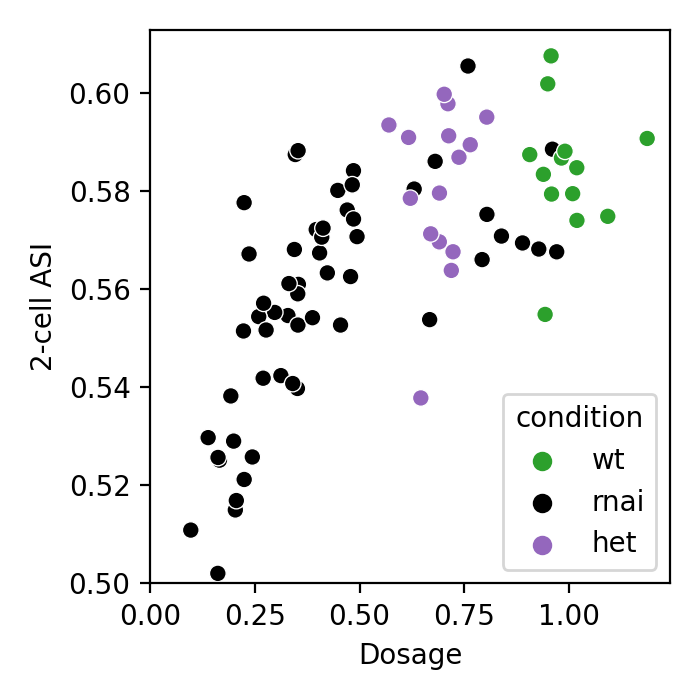

In [2]:
# Import data
df = pd.read_csv('../example datasets/dosage_vs_2cellASI_par6.csv')

# Exclude entries with missing 2-cell ASI measurements
df = df[~df['2-cell asi'].isnull()]

# Plot
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='dosage', y='2-cell asi', hue='condition', ax=ax, palette=['tab:green', 'k', 'tab:purple'])
ax.set_xlabel('Dosage')
ax.set_ylabel('2-cell ASI')
ax.set_ylim(bottom=0.5)
ax.set_xlim(left=0)
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

In [3]:
# Convert data to np arrays
xdata = df['dosage'].to_numpy()
ydata = df['2-cell asi'].to_numpy()

### Calculate variance

#### Analysis functions

In [4]:
# Gaussian weighting function
def gaus(x, centre, width):
    return np.exp(-((x - centre) ** 2) / (2 * width ** 2))

# Calculate variance
def calc_variance(xdata, ydata, xmin=-0.5, xmax=1.5, npos=100, gwidth=0.1):
    positions = np.linspace(xmin, xmax, npos)  # x positions to perform calculations
    x_mean, y_var = np.zeros(npos), np.zeros(npos)  # empty arrays for results 
    
    # Loop through positions, calculate weithed average dosage and weighted ASI variance
    for i, p in enumerate(positions):
        distances = np.abs(xdata - p)
        weights = gaus(distances, 0, gwidth)  # weight points according to distance from p
        x_mean[i] = np.average(xdata, weights=weights) # weighted average dosage
        y_mean = np.average(ydata, weights=weights) # weighted average ASI
        y_var[i] = np.average((ydata - y_mean)**2, weights=weights) # weighted ASI variance
    return positions, x_mean, y_var

#### Interactive figure - effect of Gaussian width

<IPython.core.display.Javascript object>


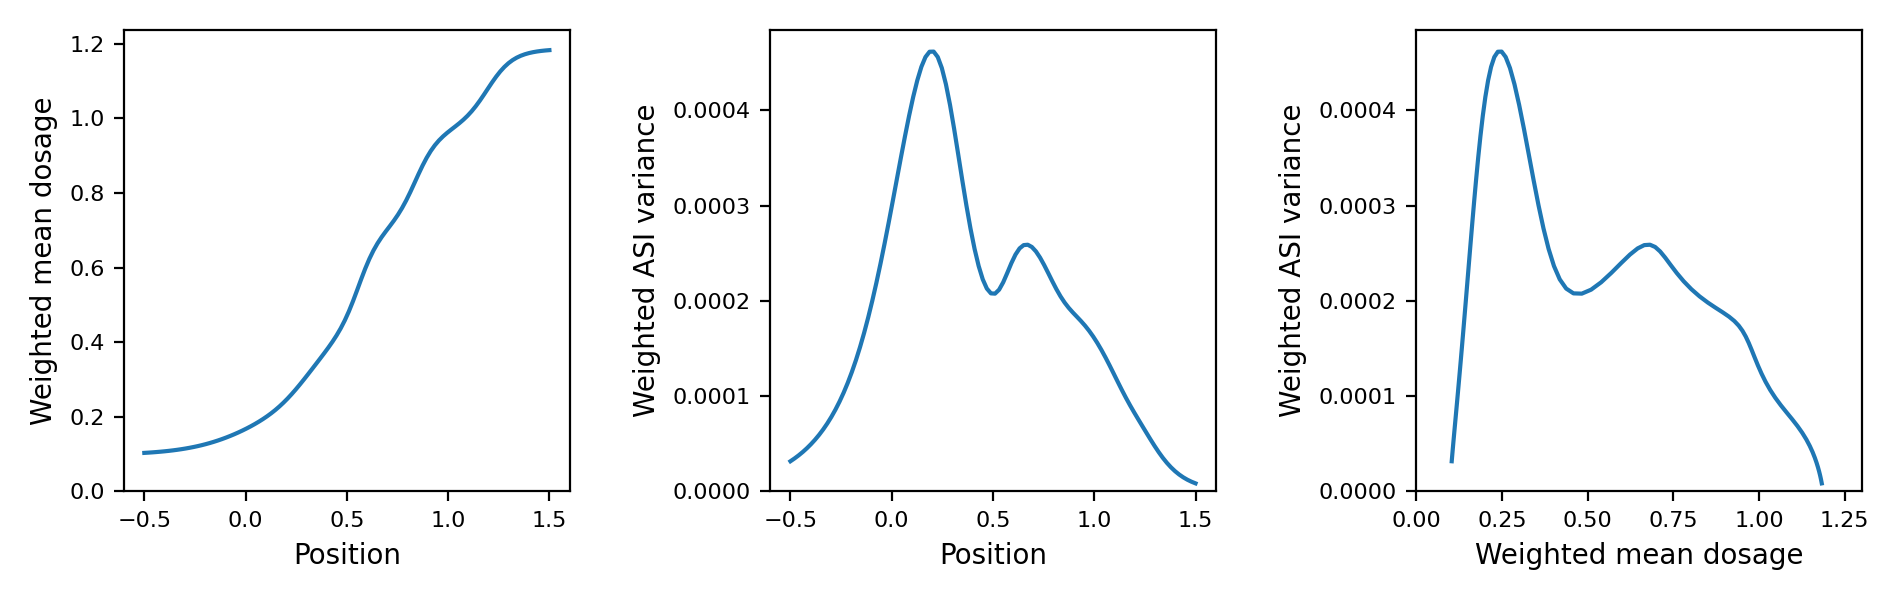

interactive(children=(FloatSlider(value=0.1, description='gwidth', max=0.3, min=0.05, step=0.01), Output()), _…

In [5]:
fig, ax = plt.subplots(1, 3)
@widgets.interact(gwidth=(0.05, 0.3, 0.01))
def update(gwidth=0.1): 
    positions, x_mean, y_var = calc_variance(xdata, ydata, gwidth=gwidth)
    
    # A: weighted mean dosage vs position
    ax[0].clear()
    ax[0].plot(positions, x_mean)
    ax[0].set_xlabel('Position')
    ax[0].set_ylabel('Weighted mean dosage')
    ax[0].tick_params(axis='both', labelsize=8)
    ax[0].set_ylim(bottom=0)

    # B: weighted ASI variance vs position
    ax[1].clear()
    ax[1].plot(positions, y_var)
    ax[1].set_xlabel('Position')
    ax[1].set_ylabel('Weighted ASI variance')
    ax[1].tick_params(axis='both', labelsize=8)
    ax[1].set_ylim(bottom=0)

    # C: weighted ASI variance vs weighted mean dosage <- this is what we're interested in
    ax[2].clear()
    ax[2].plot(x_mean, y_var)
    ax[2].set_xlim(0, 1.3)
    ax[2].set_xlabel('Weighted mean dosage')
    ax[2].set_ylabel('Weighted ASI variance')
    ax[2].tick_params(axis='both', labelsize=8)
    ax[2].set_ylim(bottom=0)

fig.set_size_inches(9.5, 3)
fig.tight_layout()
fig.subplots_adjust(wspace=0.45)

### Bootstrap

In [6]:
# Specify parameters
gwidth = 0.1  ### <- width of Gaussian weighting function
n_bootstrap = 1000 ### <- number of bootstrap samples

# Perform bootstrapping
bootstrap_x_mean, bootstrap_y_var = [], []  # empty results containers
for i in range(n_bootstrap):  
    inds = np.random.choice(range(len(ydata)), len(ydata))  # select data
    positions, _x_mean, _y_var = calc_variance(xdata[inds], ydata[inds], gwidth=gwidth)  # calculate variance
    bootstrap_x_mean.append(_x_mean)
    bootstrap_y_var.append(_y_var)

<IPython.core.display.Javascript object>


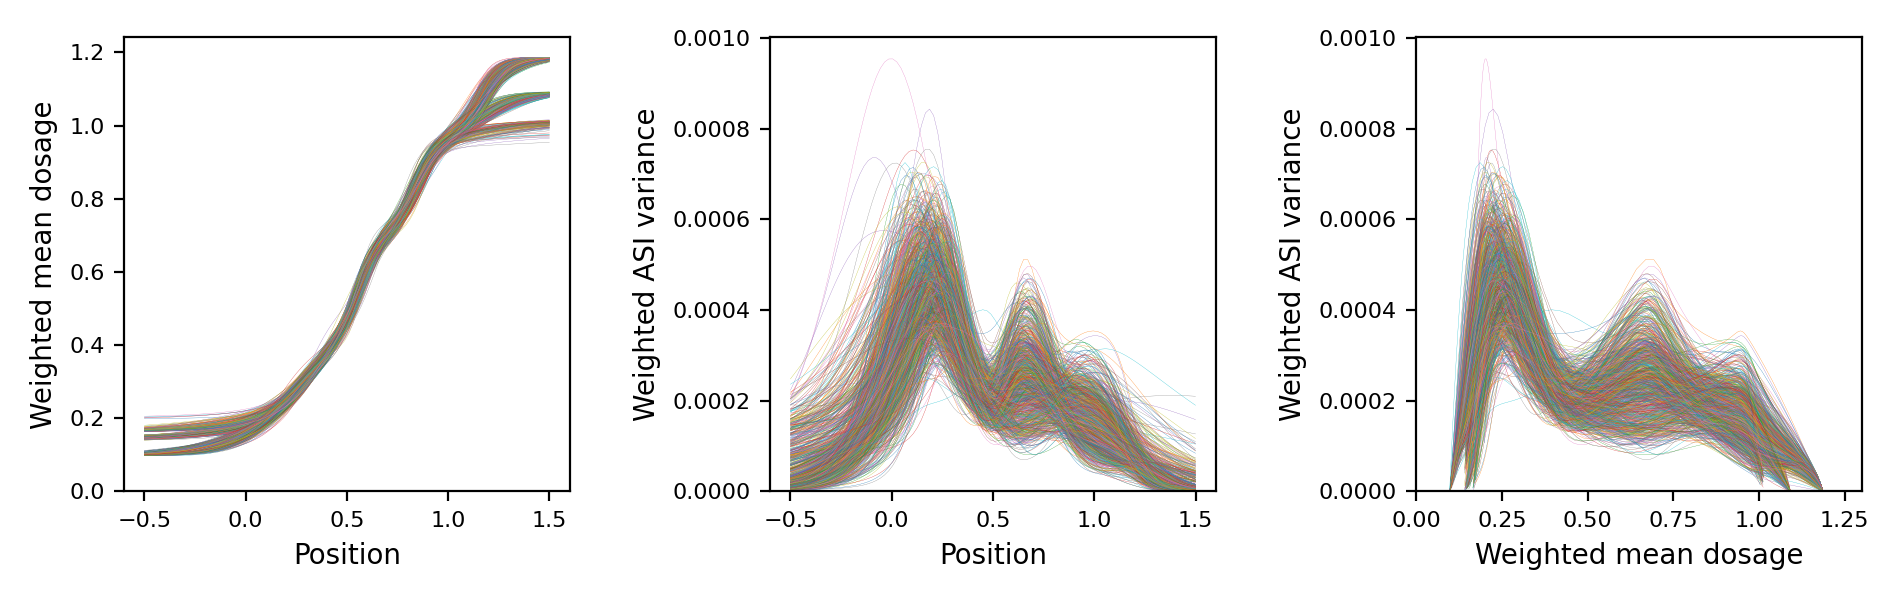

In [7]:
fig, ax = plt.subplots(1, 3)

# A: weighted mean dosage vs position
for i in bootstrap_x_mean:
    ax[0].plot(positions, i, linewidth=0.1)
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Weighted mean dosage')
ax[0].tick_params(axis='both', labelsize=8)
ax[0].set_ylim(bottom=0)


# B: weighted ASI variance vs position
for i in bootstrap_y_var:
    ax[1].plot(positions, i, linewidth=0.1)
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Weighted ASI variance')
ax[1].tick_params(axis='both', labelsize=8)
ax[1].set_ylim(bottom=0)

# C: weighted ASI variance vs weighted mean dosage <- this is what we're interested in
for i, j in zip(bootstrap_x_mean, bootstrap_y_var):
    ax[2].plot(i, j, linewidth=0.1)
ax[2].set_xlim(0, 1.3)
ax[2].set_xlabel('Weighted mean dosage')
ax[2].set_ylabel('Weighted ASI variance')
ax[2].tick_params(axis='both', labelsize=8)
ax[2].set_ylim(bottom=0)

fig.set_size_inches(9.5, 3)
fig.tight_layout()
fig.subplots_adjust(wspace=0.45)

### Crop dosage range

Cropping dosage range to regions covered by a threshold number of bootstrap experiments (default 95%)

In [8]:
threshold = 0.95 * n_bootstrap

#### Calculate dosage range

i.e. finding the range of dosages covered by the threshold number of bootstrap experiments

In [9]:
test_dosages = np.linspace(0, 1.3, 1000)  # dosage values at which to perform counting
left = np.array(bootstrap_x_mean)[:, 0]  # minumum dosage covered by each bootstrap experiment
right = np.array(bootstrap_x_mean)[:, -1]  # maximum dosage covered by each bootstrap experiment
counts = np.zeros(len(test_dosages))  # empty results contained
for i, d in enumerate(test_dosages):
    counts[i] = (np.sum((left < d) * (right > d))) # number of bootstrap samples covered by dosage d
    
xmin = test_dosages[np.where(counts > threshold)[0][0]]  # minimum threshold dosage
xmax = test_dosages[np.where(counts > threshold)[0][-1]]  # maximum threshold dosage

<IPython.core.display.Javascript object>


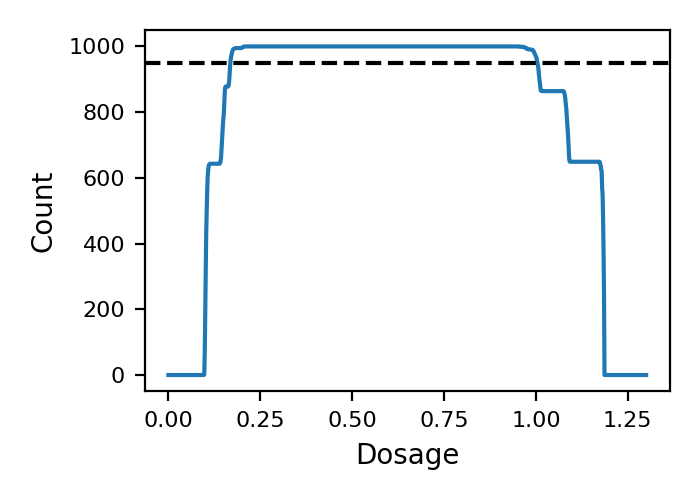

In [10]:
fig, ax = plt.subplots()
ax.plot(test_dosages, counts)
ax.axhline(threshold, c='k', linestyle='--')
ax.set_xlabel('Dosage')
ax.set_ylabel('Count')
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()

#### Crop bootstrap experiments by interpolation

Cropping all bootstrap experiments to within this range

In [11]:
cropped_positions = np.linspace(xmin, xmax, 100)
y_interp = np.zeros([len(bootstrap_x_mean), 100])
for i, (x, y) in enumerate(zip(bootstrap_x_mean, bootstrap_y_var)):
    y_interp[i, :] = interp1d(x, y, bounds_error=False)(cropped_positions)

<IPython.core.display.Javascript object>


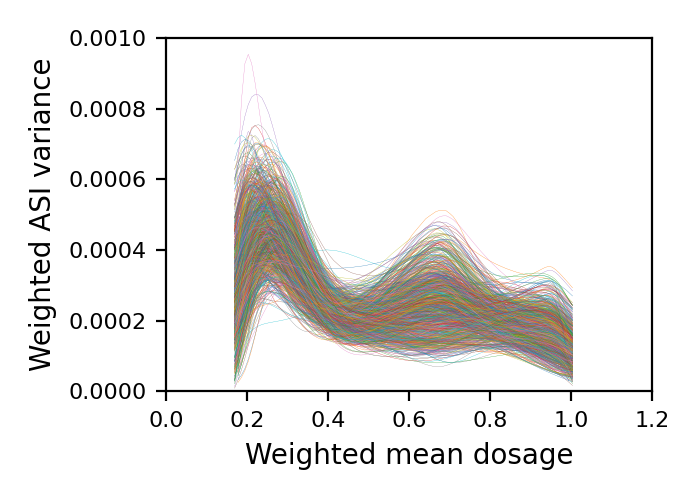

In [12]:
fig, ax = plt.subplots()
for i in y_interp:
    ax.plot(cropped_positions, i, linewidth=0.1)
ax.set_xlim(0, 1.2)
ax.set_xlabel('Weighted mean dosage')
ax.set_ylabel('Weighted ASI variance')
ax.tick_params(axis='both', labelsize=8)
ax.set_ylim(bottom=0)
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()

### Calculate confidence interval

In [13]:
interval = 95 ### <- confidence interval to calculate

# Analyse and crop full dataset
_, x_mean, y_var = calc_variance(xdata, ydata, gwidth=gwidth)
y_var_cropped = interp1d(x_mean, y_var, bounds_error=False)(cropped_positions)

# Calculate confidence interval from bootstrap experiments
res_lower = np.nanpercentile(y_interp, (100 - interval) / 2, axis=0)
res_upper = np.nanpercentile(y_interp, 50 + (interval / 2), axis=0)  

<IPython.core.display.Javascript object>


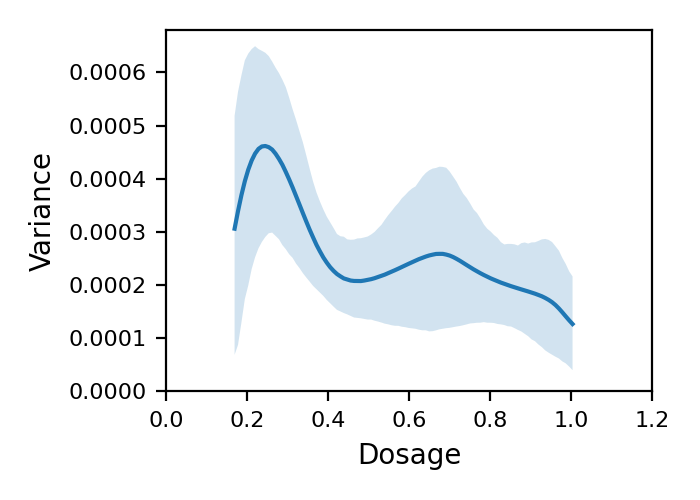

In [14]:
fig, ax = plt.subplots()
ax.plot(cropped_positions, y_var_cropped)
ax.fill_between(cropped_positions, res_lower, res_upper, alpha=0.2)
ax.set_xlim(0, 1.2)
ax.set_ylim(bottom=0)
ax.set_xlabel('Dosage')
ax.set_ylabel('Variance')
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()